# Przeszukiwanie i optymalizacja - dokumentacja końcowa

Mikołaj Szawerda, Dawid Kaszyński

W eksperymentach wykorzystamy następujące funkcje:
- Prostą funkcję y1 zdefiniowaną poniżej
- f1, f4 oraz f5 ze zbioru cec2017 w wersjach 2 oraz 10 wymiarowych

In [2]:
import math
import numpy as np
import pandas as pd
import concurrent.futures
import time
from typing import Callable
from matplotlib import pyplot as plt
from functools import partial
from cec2017.functions import f1, f4, f5
from evolutionary_algorithm import classic_evolution, elite_selection, random_selection, fitness_proportionate_selection, generation_selection, density_selection, Specimen, Log

/tmp/ipykernel_231798/2655895970.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [4]:
# f(x,y) = 17(x-3)^2 + 2(y+15)^2 - (x-3)(y+5) + 5
def y1(x):
    return 9*(x[0]-3)**2 + 2*(x[1]+15)**2 - (x[0]-3) * (x[1]+15) + 5  

## Założenia

Wszystkie eksperymenty wykonamy na stałych parametrach algorytmu, typowych dla klasycznego algorytmu ewolucyjnego:
- rozmiar populacji 40
- liczba iteracji 250
- ograniczenia kostkowe przestrzeni [-100, 100]
- Siła mutacji 0.5

Wnioski będą wyciągane na podstawie statystyk (najlepszy rezultat, średnia, odchylenie standardowe) z próby `N_TESTS` = 10 uruchomień.

**Badane metody sukcesji**:
- Sukcesja elitarna - polega na zapewnieniu przetrwania najlepszych osobników z poprzedniej populacji.
- Losowe zastępowanie osobników - do następnej populacji przechodzą losowe osobniki, bez względu na funkcję oceny
- Losowe zastępowanie osobników z prawdopodobieństwem wyboru proporcjonalnym do oceny 
- Sukcesja generacyjna - do następnej populacji przechodzi cała populacja mutantów
- Sukcesja gęstościowa (preferencja zróżnicowanych osobników) - eksperymentalne podejście polegające na dążeniu populacji do jak największego rozproszenia w celu zapewnienia dużej eksploracji.

In [5]:
# Experiment parameters
TEST_FUNCTIONS = [(y1, 2), (f1, 2), (f1, 10), (f4, 2), (f4, 10), (f5, 2), (f5, 10)]  # (function, dimensions)
SELECTION_METHODS = {
    "elite": partial(elite_selection, elite_size=1),
    "random": random_selection, 
    "proportionate": fitness_proportionate_selection,
    "generation": generation_selection,
    "density": density_selection,
}
N_TESTS = 10
POPULATION_SIZE = 40
MUTATION_STRENGTH = 0.5
T_MAX = 250
BOUNDS = (-100, 100)

## Analiza

Dla każdej z testowanych metod sukcesji oraz funkcji obliczmy zagregowane statystyki w celu dalszych analiz i wizualizacji:
- Średni czas trwania algorytmu
- Punkt, dla którego algorytm uzyskał najlepszy rezultat spośród wszystkich uruchomień
- Najlepszy rezultat algorytmu spośród wszystkich uruchomień
- Średni wynik algorytmu
- Odchylenie standardowe wyników algorytmu
- Średnią wartość populacji w kolejnych iteracjach algorytmu
- Średnią wartość populacji w kolejnych iteracjach algorytmu dla uruchomienia, które osiągnęło najlepszy wynik
- Lista najlepszych rezultatów z każdego uruchomienia

Poniżej znajdują się funkcje dokonujące pomiarów do dalszej analizy. W celu zmniejszenia czasu wykonania eksperymentów do obliczeń wykorzystywane są osobne procesy, po czym dane są agregowane.

In [6]:
def calculate_average_scores(populations):
    return [np.average([specimen.score for specimen in population]) for population in populations]

def run_algorithm_test(test_function_idx: int, selection_method_name: str)-> dict:
    results = []
    
    for i in range(N_TESTS):
        s = time.time()
        
        best, log = classic_evolution(
            TEST_FUNCTIONS[test_function_idx][0], 
            POPULATION_SIZE, 
            TEST_FUNCTIONS[test_function_idx][1], 
            BOUNDS, 
            T_MAX, 
            MUTATION_STRENGTH, 
            SELECTION_METHODS[selection_method_name]
        )
        
        e = time.time()
        results.append({
            "run_time": e-s, 
            "x": best.x,
            "score": best.score,
            "avg_pop_score_iter": calculate_average_scores(log),
            "best_score_per_iter": [min(pop, key=lambda specimen: specimen.score).score for pop in log]
        })
        
    best_result = min(results, key=lambda r: r["score"])
    
    return {
        "avg_run_time": np.average([r["run_time"] for r in results]),
        "best_x": best_result["x"],
        "best_score": best_result["score"],
        "avg_score": np.average([r["score"] for r in results]),
        "score_stdev": np.std([r["score"] for r in results]),
        "avg_pop_score_per_iter": [
            np.average([r["avg_pop_score_iter"][i] for r in results]) 
            for i in range(len(results[0]["avg_pop_score_iter"]))
        ],
        "best_pop_score_per_iter": best_result["avg_pop_score_iter"],
        "best_score_per_iter": best_result["best_score_per_iter"],
        "best_score_per_run": [result['score'] for result in results]
    }
    

In [93]:
with concurrent.futures.ProcessPoolExecutor() as executor:
    futures = []
    
    for selection_method_name, selection_method in SELECTION_METHODS.items():
        for test_function_idx, test_function in enumerate(TEST_FUNCTIONS):
            futures.append({
                "selection_method": selection_method_name,
                "function": f"{test_function[0].__name__}_{test_function[1]}d",
                "feature": executor.submit(
                    run_algorithm_test, test_function_idx, selection_method_name)
            })
     
    results = [{
        "selection_method": f["selection_method"],
        "function": f["function"],
        **f["feature"].result()
    } for f in futures]


In [94]:
df = pd.DataFrame(results)
df.head()

,selection_method,function,avg_run_time,best_x,best_score,avg_score,score_stdev,avg_pop_score_per_iter,best_pop_score_per_iter,best_score_per_iter,best_score_per_run
0,elite,y1_2d,0.29110,"[2.9973566070153566, -15.000218579122206]",5.00006,5.00068,0.00043,"[38806.93249453329, 20315.851798070158, 11021....","[41054.110709182976, 26992.626438457857, 12533...","[2687.7473262136814, 2626.5046454956687, 2369....","[5.0005704293687785, 5.000097661188195, 5.0001..."
1,elite,f1_2d,0.47361,"[-56.52222707650486, -69.88928503930074]",103.20753,944.16672,649.17187,"[119213198113.84062, 51359623447.51554, 174635...","[101826298973.64334, 40180119591.36432, 686800...","[120926.87518361803, 52928.02347742539, 52928....","[2031.0154044842463, 1083.5835917962625, 118.2..."
2,elite,f1_10d,0.47748,"[-48.66246104683117, -70.32357846441974, -28.7...",19811087.69507,8145660234.73223,11413669581.15591,"[729718484302.0308, 545373991162.7752, 4245179...","[742170238600.4763, 515065345169.3561, 3836102...","[134018803605.84018, 132986585769.13264, 13230...","[2157697375.1140547, 1299657253.9595194, 97369..."
3,elite,f4_2d,0.47499,"[32.509284289483396, 7.749562052602549]",400.00000,400.13595,0.37010,"[824.2678017282991, 555.7703495723055, 444.234...","[846.2949114628942, 545.0037209072121, 429.473...","[400.11299493768723, 400.11299493768723, 400.0...","[400.00000507123883, 400.0000013066206, 400.00..."
4,elite,f4_10d,0.74861,"[18.6632094361939, 91.03882343039778, -83.6950...",438.53921,496.14826,69.65807,"[28485.238030635614, 17722.801242471203, 11111...","[30800.02212156473, 18917.50974648426, 11477.0...","[3474.8027086971706, 3474.8027086971706, 3374....","[591.2512353253989, 445.62316249884884, 463.68..."


### Wpływ na znajdywanie optimum

W poniższej tabeli znajduje się kompletne porównanie metod selekcji dla wszystkich testowych funkcji pod względem skuteczności znajdywania minimum. Uwzględniamy najlepszy wynik spośród wszystkich uruchomień, średni wynik oraz odchylenie standardowe.

In [95]:
df[["selection_method", "function", "best_score", "avg_score", "score_stdev"]].sort_values(by=["selection_method", "function", "best_score"])

,selection_method,function,best_score,avg_score,score_stdev
30,density,f1_10d,140883540398.80969,246936322135.55463,97699581763.49675
29,density,f1_2d,512.20515,378340830.22486,621601024.82776
32,density,f4_10d,1920.12363,3197.15189,790.90729
31,density,f4_2d,400.00499,400.74316,0.88448
34,density,f5_10d,592.93864,634.86816,20.31733
33,density,f5_2d,501.00011,504.69053,3.78552
28,density,y1_2d,22.29347,682.05406,432.33004
2,elite,f1_10d,19811087.69507,8145660234.73223,11413669581.15591
1,elite,f1_2d,103.20753,944.16672,649.17187
4,elite,f4_10d,438.53921,496.14826,69.65807


#### Najskuteczniejsza metoda pod względem najlepszego wyniku spośród wszystkich uruchomień

Jak widać w poniższym zestawieniu, sukcesja elitarna wygrywa dla większości funkcji. Dla funkcji f5 to jednak sukcesja generacyjna, która nie posiada żadnych uprzywilejowanych osobników (co wpływa na jej większą zdolność do eksploracji) spisuje się lepiej. 
Dla funkcji y1 najlepszy wynik osiągnęła teoretycznie sukcesja proporcjonalna, natomiast gdy spojrzymy na kompletne zestawienie powyżej to zobaczymy, że tak na prawdę różnice pomiędzy wszystkimi 4 metodami są pomijalne.

Sukcesja losowa i gęstościowa wypadały gorzej od pozostałych we wszystkich przypadkach.

In [28]:
df[df.groupby(['function'])['best_score'].transform("min") == df['best_score']][
    ["function", "selection_method", "best_score"]].sort_values(by=["function", "selection_method"])

,function,selection_method,best_score
2,f1_10d,elite,17681738.61496
8,f1_2d,random,100.35138
25,f4_10d,generation,403.81082
3,f4_2d,elite,400.00000
20,f5_10d,proportionate,538.03507
26,f5_2d,generation,500.00003
14,y1_2d,proportionate,5.00000


#### Najskuteczniejsza metoda pod względem średniego wyniku

Sytuacja ma się tutaj analogiczni, z wyjątkiem funkcji y1. Godny uwagi jest fakt, że średnie wartości odbiegają trochę od najlepszych uzyskanych wyników, dlatego podczas testowania algorytmów optymalizacyjnych dobrze jest wielokrotnie uruchamiać ten sam algorytm.

In [29]:
df[df.groupby(['function'])['avg_score'].transform("min") == df['avg_score']][
    ["function", "selection_method", "avg_score"]].sort_values(by=["function", "selection_method"])

,function,selection_method,avg_score
2,f1_10d,elite,4269232131.33830
22,f1_2d,generation,1242.27701
4,f4_10d,elite,474.70520
3,f4_2d,elite,400.00000
6,f5_10d,elite,573.51345
5,f5_2d,elite,502.08951
14,y1_2d,proportionate,5.00024


#### Najskuteczniejsza metoda pod względem odchylenia standardowego

In [30]:
df[df.groupby(['function'])['score_stdev'].transform("min") == df['score_stdev']][
    ["function", "selection_method", "score_stdev"]].sort_values(by=["function", "selection_method"])

,function,selection_method,score_stdev
2,f1_10d,elite,4473837155.68058
22,f1_2d,generation,1403.10775
4,f4_10d,elite,44.85934
3,f4_2d,elite,0.00001
34,f5_10d,density,13.85491
5,f5_2d,elite,1.80473
0,y1_2d,elite,0.00012


### Analiza krzywych ECDF
Dla rezultatów z wielu uruchomień algorytmów zostanie przeprowadzona analiza krzywych ECDF na podstawie znalezionej optymalnej wartości

Text(0.5, 1.0, 'Krzywa ECDF dla f5_10d dla selekcji gęstościowej')

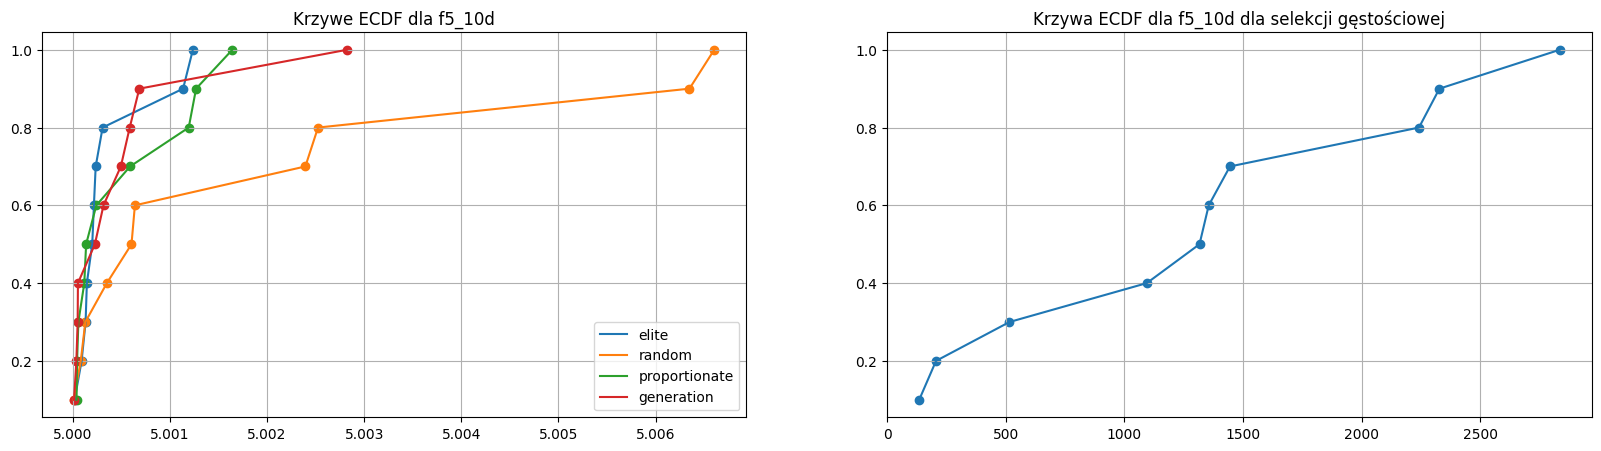

In [92]:
y = np.arange(1, N_TESTS+1) / N_TESTS
def plot_edf(selection_method, ax):
    ecdf_row = df[(df["function"] == "f5_10d") & (df["selection_method"] == selection_method)]["best_score_per_run"].tolist()[0]
    ecdf_row.sort()
    ax.plot(ecdf_row, y, label=selection_method)
    ax.scatter(ecdf_row, y)
    
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
for selection_method in SELECTION_METHODS.keys():
    if selection_method == 'density':
        continue
    plot_edf(selection_method, axs[0])
    
axs[0].legend()
axs[0].grid()
axs[0].set_title("Krzywe ECDF dla f5_10d")

plot_edf('density', axs[1])
axs[1].grid()
axs[1].set_title("Krzywa ECDF dla f5_10d dla selekcji gęstościowej")

Zaproponowana selekcja gęstościowa w żadnym z uruchomień nie osiągneła otoczenia optimum i ugrzęzła w optimum lokalnym 
Z wykreślonych wykresów należy stwierdzić, że jednoznacznie najgorsze rezultaty(z pośród algorytmów dających sensowne wyniki) wykazuje sukcesja losowa - przybliżenie optimum osiągane najwolniej i z mniejszą dokładnością.
Najlepszymi rezultatami wykazała się sukcesja elitarna
    - najszybciej osiągała przybliżenie optimum
    - osiągnęła najlepsze przybliżenie optimum
Należy również zauważyć iż sukcjesja elitarna, proporcjonalna i generacja osiągneły w miarę zbliżone rezultaty

### Zbieżność populacji algorytmu

Na przykładzie funkcji f1_2d oraz f5_10d zwizualizujemy dwie zależności:
- przebieg średniej oceny funkcji celu populacji w kolejnych iteracjach algorytmu
- przebieg oceny najlepszego punktu w iteracji algorytmu, która osiągnęła najlepszy rezultat

Eksperymenty te pokażą, że wszystkie metody sukcesji zapewniają lepszą lub gorszą zbieżność algorytmu do optimum, z wyjątkiem sukcesji gęstościowej, która przynosi całkowicie odwrotny efekt od pożądanego i zamiast w kolejnych iteracjach polepszać wynik, to średnio jest on coraz gorszy. Wynika to z fatalnych właściwości eksploatacyjnych takiego podejścia. Populacja staje się bardzo rozproszona i nie zbiega w żadno optimum.

#### Funkcja f1_2d

Wszystkie 4 metody sukcesji powodują szybkie znalezienie punktów z otoczenia optimum. Sukcesja losowa ma jednak gorszą eksploatację, zatem zbiega do niego nieznacznie wolniej i z mniejszą dokładnością.

Interesującą właściwość możemy zaobserwować dla sukcesji gęstościowej - średnia funkcja oceny w populacji spada z iteracji na iterację.

Text(0.5, 1.0, 'Sukcesja gęstościowa')

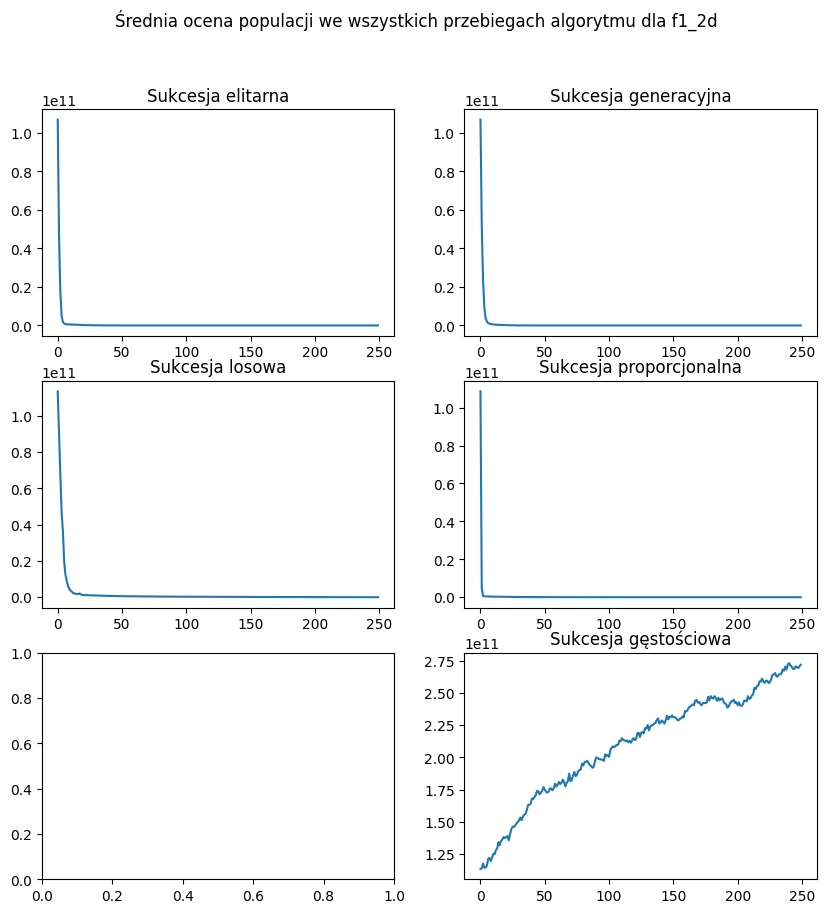

In [40]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10))
fig.suptitle("Średnia ocena populacji we wszystkich przebiegach algorytmu dla f1_2d")

axs[0, 0].plot(df[(df["function"] == "f1_2d") & (df["selection_method"] == "elite")]["avg_pop_score_per_iter"].tolist()[0])
axs[0, 0].set_title('Sukcesja elitarna')

axs[0, 1].plot(df[(df["function"] == "f1_2d") & (df["selection_method"] == "generation")]["avg_pop_score_per_iter"].tolist()[0])
axs[0, 1].set_title('Sukcesja generacyjna')

axs[1, 0].plot(df[(df["function"] == "f1_2d") & (df["selection_method"] == "random")]["avg_pop_score_per_iter"].tolist()[0])
axs[1, 0].set_title('Sukcesja losowa')

axs[1, 1].plot(df[(df["function"] == "f1_2d") & (df["selection_method"] == "proportionate")]["avg_pop_score_per_iter"].tolist()[0])
axs[1, 1].set_title('Sukcesja proporcjonalna')

axs[2, 1].plot(df[(df["function"] == "f1_2d") & (df["selection_method"] == "density")]["avg_pop_score_per_iter"].tolist()[0])
axs[2, 1].set_title('Sukcesja gęstościowa')

Text(0.5, 1.0, 'Sukcesja gęstościowa')

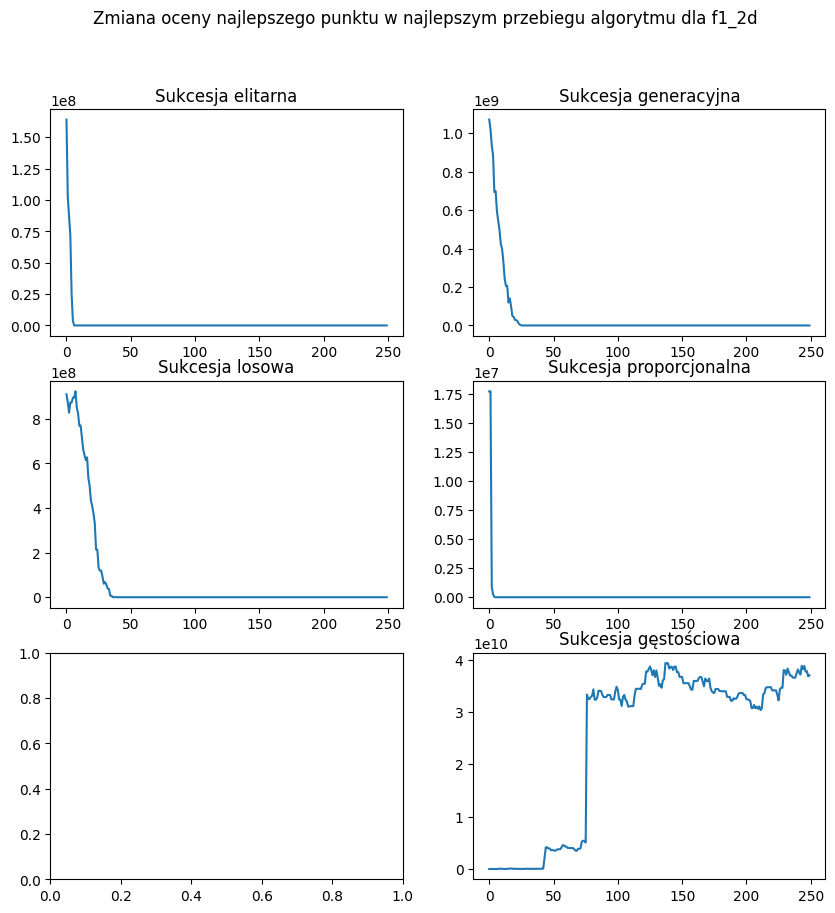

In [41]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10))
fig.suptitle("Zmiana oceny najlepszego punktu w najlepszym przebiegu algorytmu dla f1_2d")

axs[0, 0].plot(df[(df["function"] == "f1_2d") & (df["selection_method"] == "elite")]["best_score_per_iter"].tolist()[0])
axs[0, 0].set_title('Sukcesja elitarna')

axs[0, 1].plot(df[(df["function"] == "f1_2d") & (df["selection_method"] == "generation")]["best_score_per_iter"].tolist()[0])
axs[0, 1].set_title('Sukcesja generacyjna')

axs[1, 0].plot(df[(df["function"] == "f1_2d") & (df["selection_method"] == "random")]["best_score_per_iter"].tolist()[0])
axs[1, 0].set_title('Sukcesja losowa')

axs[1, 1].plot(df[(df["function"] == "f1_2d") & (df["selection_method"] == "proportionate")]["best_score_per_iter"].tolist()[0])
axs[1, 1].set_title('Sukcesja proporcjonalna')

axs[2, 1].plot(df[(df["function"] == "f1_2d") & (df["selection_method"] == "density")]["best_score_per_iter"].tolist()[0])
axs[2, 1].set_title('Sukcesja gęstościowa')

W przypadku sukcesji gęstościowej należy zwrócić uwagę na nagły skok wartości najlepszego punktu - populacja przeniosła się optimum lokalnego o mocniejszym przyciąganiu i nie była w stanie go opóścić

#### Funkcja f5_10d

Funkcja ta jest znacznie trudniejszym przypadkiem niż 2-wymiarowa funkcja f2. Na wykresach możemy zaobserwować wyraźniejsze różnice w działaniu poszczególnych metod. Zdecydowanie widać tutaj działanie elity na szybszą eksploatację algorytmu. Ponadto sukcesja proporcjonalna ma gorszą eksplorację niż generacyjna, a losowa spisuje się gorzej od pozostałych pod każdym względem.

Dla sukcesji gęstościowej możemy zaobserwować analogiczną właściwość jak w poprzedniej funkcji.

Text(0.5, 1.0, 'Sukcesja gęstościowa')

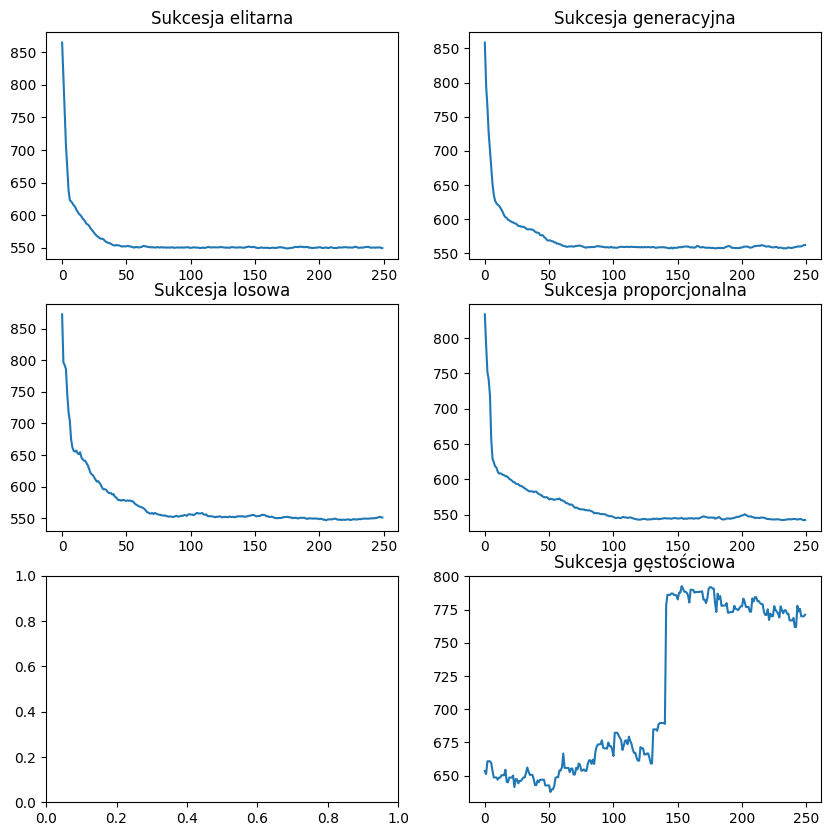

In [42]:
_, axs = plt.subplots(3, 2, figsize=(10, 10))
axs[0, 0].plot(df[(df["function"] == "f5_10d") & (df["selection_method"] == "elite")]["best_pop_score_per_iter"].tolist()[0])
axs[0, 0].set_title('Sukcesja elitarna')

axs[0, 1].plot(df[(df["function"] == "f5_10d") & (df["selection_method"] == "generation")]["best_pop_score_per_iter"].tolist()[0])
axs[0, 1].set_title('Sukcesja generacyjna')

axs[1, 0].plot(df[(df["function"] == "f5_10d") & (df["selection_method"] == "random")]["best_pop_score_per_iter"].tolist()[0])
axs[1, 0].set_title('Sukcesja losowa')

axs[1, 1].plot(df[(df["function"] == "f5_10d") & (df["selection_method"] == "proportionate")]["best_pop_score_per_iter"].tolist()[0])
axs[1, 1].set_title('Sukcesja proporcjonalna')

axs[2, 1].plot(df[(df["function"] == "f5_10d") & (df["selection_method"] == "density")]["best_score_per_iter"].tolist()[0])
axs[2, 1].set_title('Sukcesja gęstościowa')

Text(0.5, 1.0, 'Sukcesja gęstościowa')

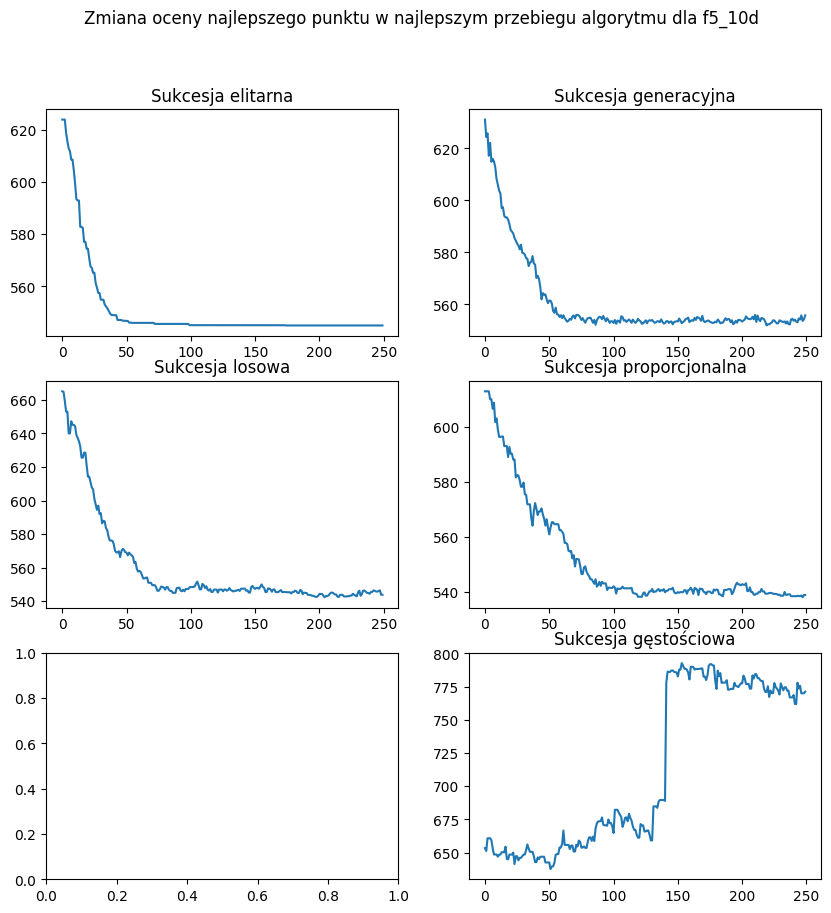

In [43]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10))
fig.suptitle("Zmiana oceny najlepszego punktu w najlepszym przebiegu algorytmu dla f5_10d")

axs[0, 0].plot(df[(df["function"] == "f5_10d") & (df["selection_method"] == "elite")]["best_score_per_iter"].tolist()[0])
axs[0, 0].set_title('Sukcesja elitarna')

axs[0, 1].plot(df[(df["function"] == "f5_10d") & (df["selection_method"] == "generation")]["best_score_per_iter"].tolist()[0])
axs[0, 1].set_title('Sukcesja generacyjna')

axs[1, 0].plot(df[(df["function"] == "f5_10d") & (df["selection_method"] == "random")]["best_score_per_iter"].tolist()[0])
axs[1, 0].set_title('Sukcesja losowa')

axs[1, 1].plot(df[(df["function"] == "f5_10d") & (df["selection_method"] == "proportionate")]["best_score_per_iter"].tolist()[0])
axs[1, 1].set_title('Sukcesja proporcjonalna')

axs[2, 1].plot(df[(df["function"] == "f5_10d") & (df["selection_method"] == "density")]["best_score_per_iter"].tolist()[0])
axs[2, 1].set_title('Sukcesja gęstościowa')

### Wpływ na czas wykonania algorytmu

Wpływ poszczególnych metod sukcesji na czas wykonania algorytmu porównamy na przykładzie funkcji f5_10d.

Jak widać na poniższym wykresie, większość z testowanych metod sukcesji nie wpływa znacząco na czas wykonania algorytmu. Wyjątek stanowi eksperymentalna sukcesja gęstościowa, która jest wolna z powodu algorytmu znajdowania najbliższych sobie punktów.
Gdy zestawimy ją z fatalnymi wynikami optymalizacji, które osiąga to dojdziemy do wniosku, że nie ma ona większej użyteczności praktycznej.

<Axes: title={'center': 'Średni czas wykonania algorytmu w zależności od metody sukcesji'}, xlabel='Metoda sukcesji'>

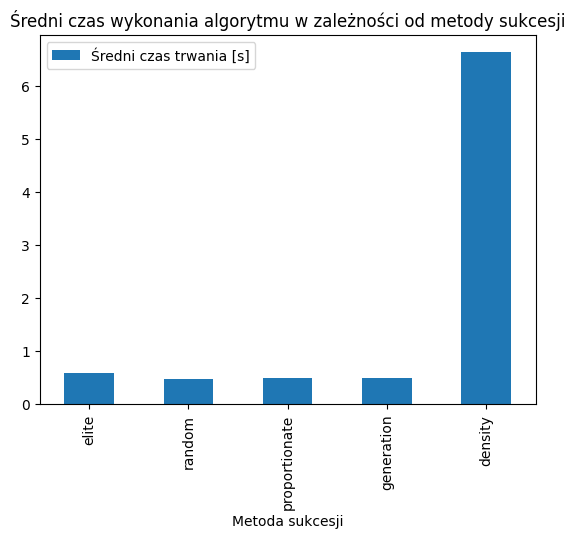

In [56]:
df[(df["function"] == "f5_10d")][["selection_method", "avg_run_time"]].rename(columns={
    "avg_run_time": "Średni czas trwania [s]", 
    "selection_method": "Metoda sukcesji"
}).set_index("Metoda sukcesji").plot(
    kind="bar", title="Średni czas wykonania algorytmu w zależności od metody sukcesji")

### Wizualizacja 2D chmury punktów dla funkcji f5
W celu lepsze zilustrowania faktycznego zachowania algorytmów zostanie wykreślony wykres zawartości loga dla każdej metody

In [96]:
def run_algorithm(test_function_idx, selection_method_name):
    _, log = classic_evolution(
            TEST_FUNCTIONS[test_function_idx][0], 
            POPULATION_SIZE, 
            TEST_FUNCTIONS[test_function_idx][1], 
            BOUNDS, 
            T_MAX, 
            MUTATION_STRENGTH, 
            SELECTION_METHODS[selection_method_name]
        )
    x_vec = [list(zip(*[spec.x for spec in iter_log])) for iter_log in log ]
    return {
        "x": [x[0] for x in x_vec],
        "y": [x[1] for x in x_vec],
        "score": [[result.score for result in iter_log] for iter_log in log ],
    }

FUNCTION_2D = (f5, 2)

with concurrent.futures.ProcessPoolExecutor() as executor:
    futures = []
    
    for selection_method_name, selection_method in list(SELECTION_METHODS.items()):
        for test_function_idx, test_function in enumerate([FUNCTION_2D]):
            futures.append({
                "selection_method": selection_method_name,
                "feature": executor.submit(
                    run_algorithm, test_function_idx, selection_method_name)
            })
    for f in futures:
        pd.DataFrame({
        **f["feature"].result()
    }).to_csv(f"../data/log_{f['selection_method']}")

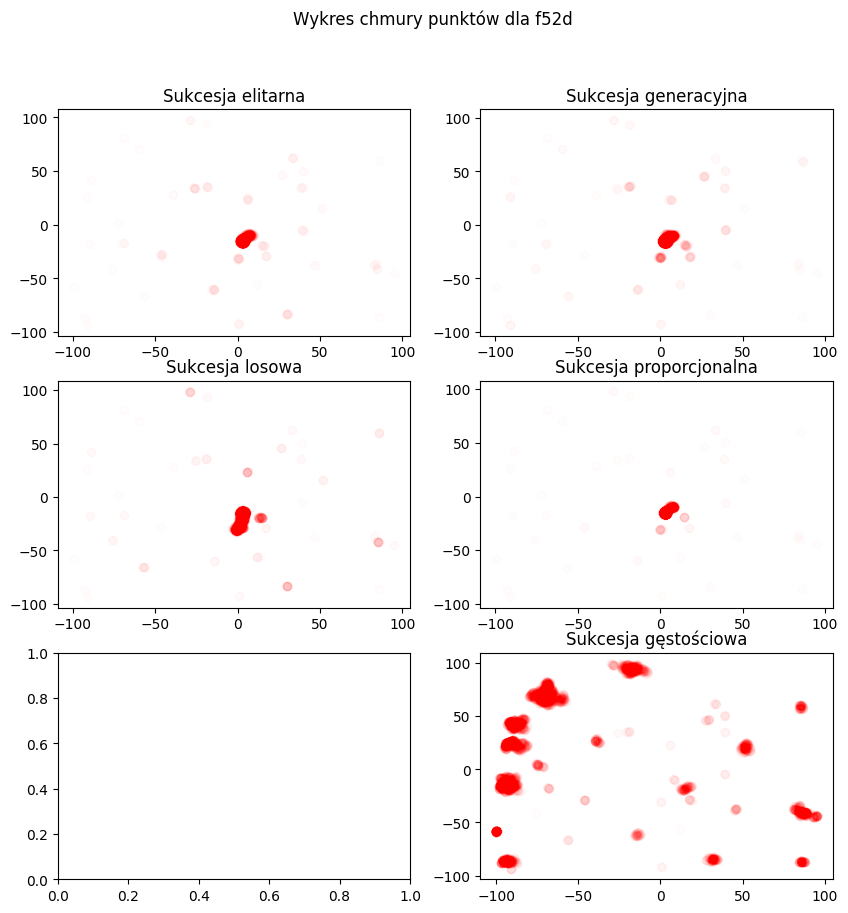

In [98]:
def plot_log(path: str, ax, title):
    import ast
    log_df = pd.read_csv(path, index_col=0)
    log_df['x'] = log_df['x'].apply(ast.literal_eval)
    log_df['y'] = log_df['y'].apply(ast.literal_eval)
    log_df['score'] = log_df['score'].apply(ast.literal_eval)
    for idx, row in log_df.iterrows():
        ax.scatter(row['x'], row['y'], alpha=0.01, color='red')
        ax.set_title(title)
        
fig, axs = plt.subplots(3, 2, figsize=(10, 10))
fig.suptitle("Wykres chmury punktów dla f52d")
plot_log("../data/log_elite", axs[0, 0], 'Sukcesja elitarna')
plot_log("../data/log_generation", axs[0, 1], 'Sukcesja generacyjna')
plot_log("../data/log_random", axs[1, 0], 'Sukcesja losowa')
plot_log("../data/log_proportionate", axs[1, 1], 'Sukcesja proporcjonalna')
plot_log("../data/log_density", axs[2, 1], 'Sukcesja gęstościowa')

Wizualizacja jednoznacznie obrazuje wcześniej opisane wnioski.
- Sukcesja elitarna dzięki własnościom eksploatacyjnych generuje więcej puktów w otoczeniu optimum- mniejsza jasność punktów po za optimum w porównaniu do innych metod oraz większe zagęszczenie lokalnych skupisk
- Z algorytmów dających sensowne rezultaty sukcesja losowa ma największą ilośc punktów poza obszarem przyciągania optimum globalnego
- Sukcesja gęstościowa wykazała silne własności eksploracyjne - punkty są rozłożone po praktycznie całym obszarze, oraz skupiają się wokół optimów lokalnych
